In [38]:
!pip install transformers

In [39]:
from google.colab import files
import pandas as pd
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
import matplotlib.pyplot as plt

# File Uploads

**Target Table**

In [4]:
print("Please upload target file as CSV: \n")

# Prompt the user to upload a file
template_file_upload = files.upload()

Please upload target file as CSV: 



Saving template.csv to template.csv


In [5]:
# Get the uploaded file name
target_file_name = next(iter(template_file_upload))

# Print the uploaded file name
print("You uploaded file:", target_file_name)

target_file_df = pd.read_csv(target_file_name)

You uploaded file: template.csv


**Table A**

In [7]:
print("Please upload source data file as CSV: \n")

# Prompt the user to upload a file
source_data_file_upload = files.upload()

Please upload source data file as CSV: 



Saving table_A.csv to table_A.csv


In [8]:
# Get the uploaded file name
source_data_file_name = next(iter(source_data_file_upload))

# Print the uploaded file name
print("You uploaded file:", source_data_file_upload)

source_file_1_df = pd.read_csv(source_data_file_name)

You uploaded file: {'table_A.csv': b'Date_of_Policy,FullName,Insurance_Plan,Policy_No,Monthly_Premium,Department,JobTitle,Policy_Start,Full_Name,Insurance_Type,Policy_Num,Monthly_Cost\n05/01/2023,John Doe,Gold Plan,AB-12345,150.00,IT,Software Engineer,05/01/2023,John Doe,Gold,AB-12345,150.00\n05/02/2023,Jane Smith,Silver Plan,CD-67890,100.00,HR,HR Manager,05/02/2023,Jane Smith,Silver,CD-67890,100.00\n05/03/2023,Michael Brown,Bronze Plan,EF-10111,50.00,Marketing,Marketing Coordinator,05/03/2023,Michael Brown,Bronze,EF-10111,50.00\n05/04/2023,Alice Johnson,Gold Plan,GH-12121,150.00,Finance,Financial Analyst,05/04/2023,Alice Johnson,Gold,GH-12121,150.00\n05/05/2023,Bob Wilson,Silver Plan,IJ-13131,100.00,Sales,Sales Executive,05/05/2023,Bob Wilson,Silver,IJ-13131,100.00\n05/06/2023,Carol Martinez,Bronze Plan,KL-14141,50.00,Operations,Operations Manager,05/06/2023,Carol Martinez,Bronze,KL-14141,50.00\n05/07/2023,David Anderson,Gold Plan,MN-15151,150.00,Legal,Attorney,05/07/2023,David Anders

**Table B**

In [10]:
print("Please upload source data file as CSV: \n")

# Prompt the user to upload a file
source_data_file_2_upload = files.upload()

Please upload source data file as CSV: 



Saving table_B.csv to table_B.csv


In [ ]:
# Get the uploaded file name
source_data_file_2_name = next(iter(source_data_file_upload))

# Print the uploaded file name
print("You uploaded file:", source_data_file_2_upload)

source_file_2_df = pd.read_csv(source_data_file_2_name)

# LLM

In [41]:
# Load the Template table
template = pd.read_csv("template.csv")

# Load table A
table_a = pd.read_csv("table_A.csv")

# Load table B
table_b = pd.read_csv("table_B.csv")

In [42]:
def find_most_similar_columns(df1, df2, model_name, similarity_threshold=0.8):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    # Create dictionaries to store the most similar columns
    most_similar_columns = {}
    decision_basis = {}

    for col1 in df1.columns:
        max_similarity = 0
        most_similar_column = None
        basis = None

        for col2 in df2.columns:
            # Concatenate all values in the column into a single string
            text1 = ' '.join(df1[col1].astype(str))
            text2 = ' '.join(df2[col2].astype(str))

            # Encode the concatenated text
            encoded_text1 = tokenizer.encode(text1, padding=True, truncation=True, return_tensors='pt')
            encoded_text2 = tokenizer.encode(text2, padding=True, truncation=True, return_tensors='pt')

            # Compute the cosine similarity between the encoded texts
            similarity = cosine_similarity(model(encoded_text1).pooler_output.detach().numpy(),
                                           model(encoded_text2).pooler_output.detach().numpy())

            # Update the most similar column if the similarity is higher
            if similarity > max_similarity:
                max_similarity = similarity
                most_similar_column = col2
                basis = {
                    'Similarity': similarity,
                    'Formats': {
                        'df1': df1[col1].dtype,
                        'df2': df2[col2].dtype
                    },
                    'Distributions': {
                        'df1': df1[col1].value_counts(normalize=True).to_dict(),
                        'df2': df2[col2].value_counts(normalize=True).to_dict()
                    },
                    # Add any other relevant features or basis for decision
                }

        # If the similarity is below the threshold, prompt the user to choose a column
        if max_similarity < similarity_threshold:
            print(f"Ambiguous similarity for column '{col1}'.")
            print(f"Similarity value: {max_similarity}")
            print(f"Choose from the following columns in df2: {df2.columns}")
            selected_column = input(f"Enter the chosen column for '{col1}': ")
            most_similar_column = selected_column
            basis = {
                'Similarity': similarity,
                'Formats': {
                    'df1': df1[col1].dtype,
                    'df2': df2[col2].dtype
                },
                'Distributions': {
                    'df1': df1[col1].value_counts(normalize=True).to_dict(),
                    'df2': df2[col2].value_counts(normalize=True).to_dict()
                },
                # Add any other relevant features or basis for decision
            }
        most_similar_columns[col1] = most_similar_column
        decision_basis[col1] = basis

    return most_similar_columns, decision_basis

In [43]:
model_name = 'bert-base-uncased'
similarity_threshold = 0.99

similar_columns, decision_basis = find_most_similar_columns(template, table_a, model_name, similarity_threshold)
similar_columns_b, decision_basis_b = find_most_similar_columns(template, table_b, model_name, similarity_threshold)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Ambiguous similarity for column 'PolicyNumber'.
Similarity value: [[0.91359234]]
Choose from the following columns in df2: Index(['Date_of_Policy', 'FullName', 'Insurance_Plan', 'Policy_No',
       'Monthly_Premium', 'Department', 'JobTitle', 'Policy_Start',
       'Full_Name', 'Insurance_Type', 'Policy_Num', 'Monthly_Cost'],
      dtype='object')
Enter the chosen column for 'PolicyNumber': Policy_Num
Ambiguous similarity for column 'Premium'.
Similarity value: [[0.9844731]]
Choose from the following columns in df2: Index(['Date_of_Policy', 'FullName', 'Insurance_Plan', 'Policy_No',
       'Monthly_Premium', 'Department', 'JobTitle', 'Policy_Start',
       'Full_Name', 'Insurance_Type', 'Policy_Num', 'Monthly_Cost'],
      dtype='object')
Enter the chosen column for 'Premium': Monthly_Premium


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Ambiguous similarity for column 'Date'.
Similarity value: [[0.98080254]]
Choose from the following columns in df2: Index(['PolicyDate', 'Name', 'PlanType', 'Policy_ID', 'PremiumAmount', 'Hobby',
       'MaritalStatus', 'StartDate', 'Employee_Name', 'Plan_Name', 'PolicyID',
       'Cost'],
      dtype='object')
Enter the chosen column for 'Date': StartDate


In [44]:
print(similar_columns)
print(decision_basis)

print(similar_columns_b)
print(decision_basis_b)

{'Date': 'Date_of_Policy', 'EmployeeName': 'FullName', 'Plan': 'Insurance_Type', 'PolicyNumber': 'Policy_Num', 'Premium': 'Monthly_Premium'}
{'Date': {'Similarity': array([[0.9904062]], dtype=float32), 'Formats': {'df1': dtype('O'), 'df2': dtype('O')}, 'Distributions': {'df1': {'01-05-2023': 0.1, '02-05-2023': 0.1, '03-05-2023': 0.1, '04-05-2023': 0.1, '05-05-2023': 0.1, '06-05-2023': 0.1, '07-05-2023': 0.1, '08-05-2023': 0.1, '09-05-2023': 0.1, '10-05-2023': 0.1}, 'df2': {'05/01/2023': 0.1, '05/02/2023': 0.1, '05/03/2023': 0.1, '05/04/2023': 0.1, '05/05/2023': 0.1, '05/06/2023': 0.1, '05/07/2023': 0.1, '05/08/2023': 0.1, '05/09/2023': 0.1, '05/10/2023': 0.1}}}, 'EmployeeName': {'Similarity': array([[1.]], dtype=float32), 'Formats': {'df1': dtype('O'), 'df2': dtype('O')}, 'Distributions': {'df1': {'John Doe': 0.1, 'Jane Smith': 0.1, 'Michael Brown': 0.1, 'Alice Johnson': 0.1, 'Bob Wilson': 0.1, 'Carol Martinez': 0.1, 'David Anderson': 0.1, 'Eva Thomas': 0.1, 'Frank Jackson': 0.1, 'Grac

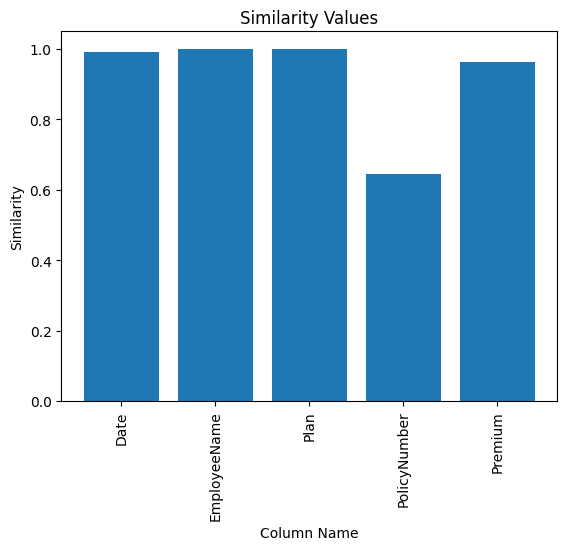

In [45]:
# Extract the similarity values from the 'decision_basis' dictionary
similarities = [basis['Similarity'] for basis in decision_basis.values()]
similarities = [arr.reshape(-1) for arr in similarities]
similarities_df = pd.DataFrame(similarities)
df_flat = similarities_df.stack().reset_index(drop=True)

# Create a bar chart of the similarity values
plt.bar(decision_basis.keys(), df_flat)
plt.xlabel('Column Name')
plt.ylabel('Similarity')
plt.title('Similarity Values')
plt.xticks(rotation=90)
plt.show()

From the histogram above, we can see that the 'PolicyNumber' and 'Premium' columns from table A had lower similarities compared to the 'Date', 'EmployeeName', & 'Plan' columns. Consequently, the algorithm prompted the user to choose the most similar column.


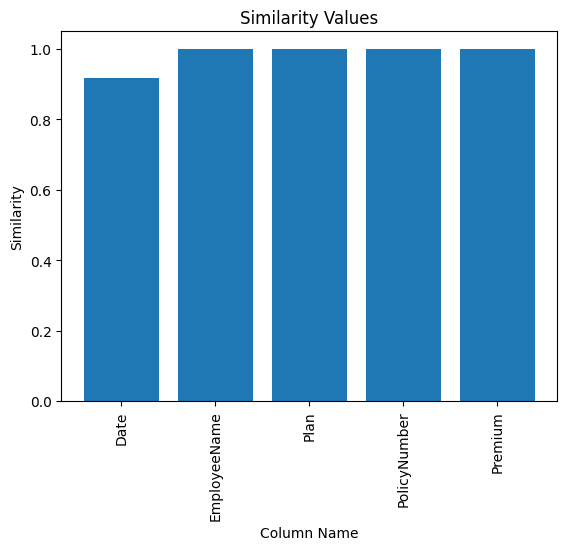

In [46]:
# Extract the similarity values from the 'decision_basis' dictionary
similarities_b = [basis['Similarity'] for basis in decision_basis_b.values()]
similarities_b = [arr.reshape(-1) for arr in similarities_b]
similarities_b_df = pd.DataFrame(similarities_b)
df_b_flat = similarities_b_df.stack().reset_index(drop=True)

# Create a bar chart of the similarity values
plt.bar(decision_basis_b.keys(), df_b_flat)
plt.xlabel('Column Name')
plt.ylabel('Similarity')
plt.title('Similarity Values')
plt.xticks(rotation=90)
plt.show()

From the histogram above, we can see that the 'Date' column from table B had a lower similarity compared with columns from the Template table, compared to the 'EmployeeName', 'Plan', 'PolicyNumber', & 'Premium' columns. Consequently, the algorithm prompted the user to choose the most similar column.

# Transformation Logic

**Since such operations can be repeated quite often, and a person will edit the transformation logic, it is desirable to save this data and have the ability to retrain on it. Propose an approach for retraining and try to implement such retraining on synthetic examples (you can come up with them using GPT =))**

The function below is reponsible for mapping the value formats from tables A and B to the value format in the template table. Anyone who wishes to edit the transformation logic can do so within the context of this function, passing in the two input tables as dataframes, as well as a dictionary mapping of the best columns from the corresponding input table to the target table.

The ability to retrain the model can be accomplished by, once again, specifying the input tables as dataframes, specifying the model name, and calling the find_most_similar_columns() function from the section above.

In [47]:
def convert_dataframe_values(df_a, df_b, column_mapping):
    new_df = pd.DataFrame()

    for col_a, col_b in column_mapping.items():
        # Get the data type of the column in dataframe A
        data_type = df_a[col_a].dtype

        def is_date(column):
          try:
              pd.to_datetime(column)
              return True
          except ValueError:
              return False

        if is_date(df_b[col_b]):
          df_b[col_b] = pd.to_datetime(df_b[col_b])

        # Convert the column values in dataframe B to the same data type
        converted_values = df_b[col_b].astype(data_type)

        # If the data type is datetime, infer the datetime format from the column value
        if data_type == 'datetime64[ns]':
            converted_values = pd.to_datetime(converted_values, infer_datetime_format=True)

        # Add the converted values to the new dataframe
        new_df[col_a] = converted_values

    return new_df

In [48]:
new_df = convert_dataframe_values(template, table_a, similar_columns)
print(new_df)

                  Date    EmployeeName    Plan PolicyNumber  Premium
0  2023-05-01 00:00:00        John Doe    Gold     AB-12345      150
1  2023-05-02 00:00:00      Jane Smith  Silver     CD-67890      100
2  2023-05-03 00:00:00   Michael Brown  Bronze     EF-10111       50
3  2023-05-04 00:00:00   Alice Johnson    Gold     GH-12121      150
4  2023-05-05 00:00:00      Bob Wilson  Silver     IJ-13131      100
5  2023-05-06 00:00:00  Carol Martinez  Bronze     KL-14141       50
6  2023-05-07 00:00:00  David Anderson    Gold     MN-15151      150
7  2023-05-08 00:00:00      Eva Thomas  Silver     OP-16161      100
8  2023-05-09 00:00:00   Frank Jackson  Bronze     QR-17171       50
9  2023-05-10 00:00:00     Grace White    Gold     ST-18181      150


In [49]:
new_df_b = convert_dataframe_values(template, table_b, similar_columns_b)
print(new_df_b)

                  Date    EmployeeName    Plan PolicyNumber  Premium
0  2023-05-01 00:00:00        John Doe    Gold      AB12345      150
1  2023-05-02 00:00:00      Jane Smith  Silver      CD67890      100
2  2023-05-03 00:00:00   Michael Brown  Bronze      EF10111       50
3  2023-05-04 00:00:00   Alice Johnson    Gold      GH12121      150
4  2023-05-05 00:00:00      Bob Wilson  Silver      IJ13131      100
5  2023-05-06 00:00:00  Carol Martinez  Bronze      KL14141       50
6  2023-05-07 00:00:00  David Anderson    Gold      MN15151      150
7  2023-05-08 00:00:00      Eva Thomas  Silver      OP16161      100
8  2023-05-09 00:00:00   Frank Jackson  Bronze      QR17171       50
9  2023-05-10 00:00:00     Grace White    Gold      ST18181      150


# Edge Case Discussion

**Your thoughts on edge cases and how they can be overcome:**

One edge case to consider is column dependencies. Suppose a column exists (i.e. Column Z), such that it's a combination (e.g. a grouping, concatenation, or aggregation) of other columns (i.e Column X & Column Y). In other words, the formulation of Column Z is dependent upon columns X & Y. Let's also suppose that there exists another column (Column A) that is similar to Column X, such that the column matching algorithm finds Column A to be more similar to a column in the target table than Column X. In such a scenario, we would run into an issue, since Column Z's integrity would no longer be maintained.

Another edge case that was touched upon with the datetime format deals with different value formats. Tables A and B may have different value formats compared to the template. For example, dates may be represented in different formats (as seen from above), numeric values may have different decimal places, or text values may have different capitalization, currency symbols, or units of measurement. As a pre-processing step, normalizing the value formats to convert values in tables A and B to match the format specified in the template, prior to performing any post-processing or model inference, could prove beneficial.